# Covid-19 Tweet Analysis Using NLP 

## Project Goal
For this project, I shall be combining 2 datasets including covid tweets and noncovid tweets. This will be able to help the Twitter team to identify the covid related tweets and allow them to connect their users with covid-19 resources developed by official health organizations. 

To achieve this goal, we shall be using natural language processing (NLP).

## Data Understanding 
**Covid-19 related dataset was collected from Kaggle, which consists of columns including information such as:**
- COLUMN NAMES: Location, date of tweet, original tweet, sentiment (positive, negative, neutral), etc.
- total number of tweets: 44955
https://www.kaggle.com/datatattle/covid-19-nlp-text-classification 
- We shall look specifically at the original tweet text, and develop a column with a “target” of 1 showing it is related to covid-19.

**The non-covid 19 dataset was also collected from Kaggle, consisting of columns including:**
- COLUMN NAMES: Target (negative, positive, neutral), ids, date, flag, user, and tweet
- total number of tweets: 1.6 million
https://www.kaggle.com/kazanova/sentiment140 
- The tweet column shall be used and a “target” column of 0 shall represent that the tweets are unrelated to covid. 


## Metrics

**Our project will answer following question:**
Can we predict tweets related to covid?

**Hypothesis:**

    H0 - The tweet is related to covid.

    HA - There is statisticaly significant proof that the tweet isn't related to covid.

**TP, TN, FP, FN definition**

    TP - we predicted covid tweet and it actually exist.

    TN - we predicted that tweet isn't covid related and the tweet actually isn't related to covid.

    FP - We predicted covid tweet but it was not a covid tweet.

    FN - We predicted that there is no covid tweet but it actually existed.

**Metrics used**
    
    To compare models we will focus on 2 major metrics:

    Recall - We will be focused to minimize FN.

    Accuracy - how good we can predict TP and TN. General metrics that will show model performance.

In [1]:
#import required modules 

from sklearn.pipeline import Pipel
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoderine
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

import matplotlib.pyplot as plt
%matplotlib inline


## Data Preparation 

1) Covid-19 dataset 
- Remove unrelated columns
- Train/test sets already separated 
- Ended up with 44955 tweets

2) Noncovid-19 dataset
- Create sample of 44955
- Remove unrelated columns 

3) Data Preprocessing 
- Remove unnecessary numbers, punctuations, etc.
- Tokenization.
- Lower casing.
- Stop words removal.
- Stemming.
- Lemmatization.

4) Create dataset with both 
- Concat test/train split
- Train for both covid & non-covid dataset
- Test for both covid & non-covid dataset

5) Vectorizer
- Count Vectorizer 
- TF-IDF Vectorizer

These vectorizers were selected to look further into training, validation, and ultimately our test set. Parameters were altered including min_df, max_features, etc. to increase performance of our models.


### Let's Organize Our Covid-19 Dataset!

In [2]:
#train_df = pd.read_csv('Documents/Flatiron/Projects/Phase 5/COVID-19-Tweets-NLP/data/Corona_NLP_train.csv')
train_df = pd.read_csv('data/Corona_NLP_train.csv',encoding='latin1')
test_df = pd.read_csv('data/Corona_NLP_test.csv',encoding='latin1')
train_df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [3]:
#we shall be using the "OriginalTweet" column using NLP
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [4]:
train_df['OriginalTweet'].value_counts().sum()

41157

In [5]:
train_df.isna().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [6]:
test_df.isna().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [7]:
test_df['OriginalTweet'].value_counts().sum()

3798

In [8]:
train_df_2 = pd.DataFrame(train_df['OriginalTweet'].astype(str))
test_df_2 = pd.DataFrame(test_df['OriginalTweet'].astype(str))

In [9]:
#let's change the target to 1 for train covid df
train_df_2["target"]=1
train_df_2

,OriginalTweet,target
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,advice Talk to your neighbours family to excha...,1
2,Coronavirus Australia: Woolworths to give elde...,1
3,My food stock is not the only one which is emp...,1
4,"Me, ready to go at supermarket during the #COV...",1
...,...,...
41152,Airline pilots offering to stock supermarket s...,1
41153,Response to complaint not provided citing COVI...,1
41154,You know itÂs getting tough when @KameronWild...,1
41155,Is it wrong that the smell of hand sanitizer i...,1


In [10]:
#let's change the target to 1 for test covid df

test_df_2['target']=1
test_df_2

,OriginalTweet,target
0,TRENDING: New Yorkers encounter empty supermar...,1
1,When I couldn't find hand sanitizer at Fred Me...,1
2,Find out how you can protect yourself and love...,1
3,#Panic buying hits #NewYork City as anxious sh...,1
4,#toiletpaper #dunnypaper #coronavirus #coronav...,1
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,1
3794,Did you panic buy a lot of non-perishable item...,1
3795,Asst Prof of Economics @cconces was on @NBCPhi...,1
3796,Gov need to do somethings instead of biar je r...,1


*As you can see our train & test covid-19 dataset has been cut down to include our index and tweet. Next, we shall add the target column to both.

In [11]:
train_df_2["tweet"] = train_df_2['OriginalTweet']
train_df_2 = train_df_2.drop(["OriginalTweet"], axis=1)
train_df_2

,target,tweet
0,1,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1,1,advice Talk to your neighbours family to excha...
2,1,Coronavirus Australia: Woolworths to give elde...
3,1,My food stock is not the only one which is emp...
4,1,"Me, ready to go at supermarket during the #COV..."
...,...,...
41152,1,Airline pilots offering to stock supermarket s...
41153,1,Response to complaint not provided citing COVI...
41154,1,You know itÂs getting tough when @KameronWild...
41155,1,Is it wrong that the smell of hand sanitizer i...


In [12]:
test_df_2["tweet"] = test_df_2['OriginalTweet']
test_df_2 = test_df_2.drop(["OriginalTweet"], axis=1)
test_df_2

,target,tweet
0,1,TRENDING: New Yorkers encounter empty supermar...
1,1,When I couldn't find hand sanitizer at Fred Me...
2,1,Find out how you can protect yourself and love...
3,1,#Panic buying hits #NewYork City as anxious sh...
4,1,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...
3793,1,Meanwhile In A Supermarket in Israel -- People...
3794,1,Did you panic buy a lot of non-perishable item...
3795,1,Asst Prof of Economics @cconces was on @NBCPhi...
3796,1,Gov need to do somethings instead of biar je r...


### Let's Organize Our Non-Covid-19 Dataset!

In [13]:
noncovid_df = pd.read_csv('data/non_covid_tweets.csv', encoding='latin1').sample(n=44955)
noncovid_df.shape

(44955, 6)

In [14]:
#We dropped the irrelevant columns for the non-covid-19 tweets
noncovid_df2 = pd.DataFrame(noncovid_df['tweet'].astype(str))
noncovid_df2.head()

,tweet
1534203,@JPcashcash fun fun! say hi to mercy mercedes ...
1436035,@comfykitty Thanks
1012124,I'ma try and get 700 tweets today
330807,WHOO-HOO! So excited 4 new phone (sorry sideki...
422674,@xoticbeauty no one


In [15]:
# Add a "target" column to noncovid_df where each row is set to 0
noncovid_df2['target']=0
noncovid_df2

,tweet,target
1534203,@JPcashcash fun fun! say hi to mercy mercedes ...,0
1436035,@comfykitty Thanks,0
1012124,I'ma try and get 700 tweets today,0
330807,WHOO-HOO! So excited 4 new phone (sorry sideki...,0
422674,@xoticbeauty no one,0
...,...,...
1278613,Jennii00what is yourfavoritecobra starshipsong?,0
1141699,@bignatewoods Well Leigh was @leighmathews bu...,0
195875,@PaulmMcC why am I not s good wife,0
649399,Also watched 'Analyze That' and disappointed ...,0


In [16]:
# Reset the index of the noncovid_df
noncovid_df2.reset_index(drop=True)
noncovid_df2

,tweet,target
1534203,@JPcashcash fun fun! say hi to mercy mercedes ...,0
1436035,@comfykitty Thanks,0
1012124,I'ma try and get 700 tweets today,0
330807,WHOO-HOO! So excited 4 new phone (sorry sideki...,0
422674,@xoticbeauty no one,0
...,...,...
1278613,Jennii00what is yourfavoritecobra starshipsong?,0
1141699,@bignatewoods Well Leigh was @leighmathews bu...,0
195875,@PaulmMcC why am I not s good wife,0
649399,Also watched 'Analyze That' and disappointed ...,0


In [17]:
noncovid_df2.isna().sum()

tweet     0
target    0
dtype: int64

## Let's combine datasets and complete preprocessing for NLP!  

In [18]:
#Concat test/train split
#Train for both covid & non-covid dataset
#Test for both covid & non-covid dataset

covid_tweets =  pd.concat([train_df_2, test_df_2], axis=0)
all_tweets = pd.concat([covid_tweets, noncovid_df2], axis = 0)
all_tweets

# set variables  
X = all_tweets.drop("target", axis=1)
y = all_tweets['target']

# test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# test/train split for validatiion set
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=1)

#Back into DF, not running these causes an error for preprocessing functions below 
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)

In [19]:
all_tweets.describe()

,target
count,89910.000000
mean,0.500000
std,0.500003
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [20]:
print("Total tweets in this data: {}".format(all_tweets.shape[0]))

Total tweets in this data: 89910


## Baseline Values:

In [21]:
print(all_tweets['target'].unique())
print(all_tweets['target'].value_counts(normalize=True))

[1 0]
1    0.5
0    0.5
Name: target, dtype: float64


In [22]:
all_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89910 entries, 0 to 342154
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  89910 non-null  int64 
 1   tweet   89910 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.1+ MB


In [23]:
# Let's begin the various text preprocessing steps:
#Tokenization.
#Lower casing.
#Stop words removal.
#Stemming.
#Lemmatization.

## Data Preprocessing 

For data preprocessing, I needed to find additional preprocessing steps and found [this resource](https://www.kaggle.com/datatattle/battle-of-ml-classification-models).

In [24]:
#initialize stopwords for removal
sw = stopwords.words('english')

In [25]:
# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
X_train['tweet']=X_train['tweet'].apply(lambda x:remove_num(x))
X_test['tweet']=X_test['tweet'].apply(lambda x:remove_num(x))

In [26]:
# remove punctuations 

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
X_train['tweet']=X_train['tweet'].apply(lambda x:punct_remove(x))
X_test['tweet']=X_test['tweet'].apply(lambda x:punct_remove(x))


In [27]:
#Remove mentions and hashtags

def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
X_train['tweet']=X_train['tweet'].apply(lambda x:remove_mention(x))
X_test['tweet']=X_test['tweet'].apply(lambda x:remove_mention(x))

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
X_train['tweet']=X_train['tweet'].apply(lambda x:remove_hash(x))
X_test['tweet']=X_test['tweet'].apply(lambda x:remove_hash(x))

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
X_train['tweet']=X_train['tweet'].apply(lambda x:remove_space(x))
X_test['tweet']=X_test['tweet'].apply(lambda x:remove_space(x))


In [28]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
X_train['tweet']=X_train['tweet'].apply(lambda x:remove_urls(x))
X_test['tweet']=X_test['tweet'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
X_train['tweet']=X_train['tweet'].apply(lambda x:remove_html(x))
X_test['tweet']=X_test['tweet'].apply(lambda x:remove_html(x))

In [29]:
#identify POS tags
def get_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [30]:
#preprocess text function - has been modified to suit our needs

def tweet_preparer(tweet_text, stopwords=sw):
    regex_token = RegexpTokenizer(r'([a-zA-Z]+)')
    tweet_text = regex_token.tokenize(tweet_text)
    tweet_text = [word.lower() for word in tweet_text]
    tweet_text = [word for word in tweet_text if word not in sw]
    tweet_text = pos_tag(tweet_text)
    tweet_text = [(word[0], get_pos(word[1])) for word in tweet_text]
    lemmatizer = WordNetLemmatizer() 
    tweet_text = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet_text]
    return tweet_text

In [31]:
#Process Training data
X_train['Tweet_tokens'] = [tweet_preparer(tweet_text, sw) for tweet_text in X_train['tweet']]

In [32]:
#process test data
X_test['Tweet_tokens'] = [tweet_preparer(tweet_text, sw) for tweet_text in X_test['tweet']]


In [33]:
#for plotting frequency distribution
from matplotlib.ticker import MaxNLocator
def plot_frequency(freq_dist, title):
    top_15 = list(zip(*freq_dist.most_common(15)))
    tokens = top_15[0]
    counts = top_15[1]
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

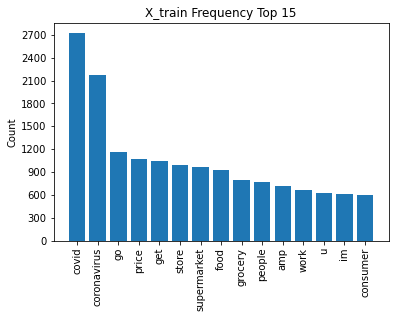

In [34]:
# plotting frequency distribution - plot of Training tokens top 15
train_freq_dist = FreqDist(X_train['Tweet_tokens'].explode())
plot_frequency(train_freq_dist, "X_train Frequency Top 15")

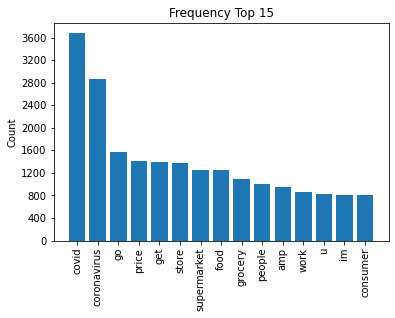

In [35]:
#plotting test freqdist words - similar results
X_testfreq_dist = FreqDist(X_test['Tweet_tokens'].explode())
plot_frequency(X_testfreq_dist, "Frequency Top 15")

Among the top 3 words that are seen in the `X_train` & `X_test` are words that relate to covid/coronavirus. 

## CountVectorizer 


In [36]:
#CountVectorizer - no limit to how many words to check performance with max_features
#fit transform train data
cvec = CountVectorizer(stop_words=sw, min_df=.000026, max_features = 27133, strip_accents='ascii')
X_t_vec = cvec.fit_transform(X_train['tweet'])
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cvec.vocabulary_)
X_t_vec.set_index(y_train.index, inplace=True)
X_t_vec

,__,___,____,_______,__________,__anthony,_anujsinghal,_bcla,_claragh__b_,_crc_,...,zoombombing,zoomupyourlife,zoos,zrhero,zune,zzzs,zzzz,zzzzz,zzzzzz,zzzzzzzzzz
459681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1077990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32218,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
576114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
329972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
409019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#CountVectorizer 
# transform val data

X_val_vec = cvec.transform(X_val['tweet'])
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cvec.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)
X_val_vec

,__,___,____,_______,__________,__anthony,_anujsinghal,_bcla,_claragh__b_,_crc_,...,zoombombing,zoomupyourlife,zoos,zrhero,zune,zzzs,zzzz,zzzzz,zzzzzz,zzzzzzzzzz
3395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
473511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
615549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1049654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#CountVectorizer - no limit to how many words to check performance with max_features
#fit transform test data
X_test_vec = cvec.transform(X_test['tweet'])
X_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cvec.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)
X_test_vec

,__,___,____,_______,__________,__anthony,_anujsinghal,_bcla,_claragh__b_,_crc_,...,zoombombing,zoomupyourlife,zoos,zrhero,zune,zzzs,zzzz,zzzzz,zzzzzz,zzzzzzzzzz
37944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
414855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7872,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
139852,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TF-IDF Vectorizer

#### 1st TF-IDF Vectorizer 

In [39]:
#1st TD-IDF vectorizer
# max_features & token_pattern are different for both 
#Fit transform training data 

tfidf = TfidfVectorizer(stop_words=sw, lowercase=True, max_features=27133, token_pattern=r'([a-z]{3,})', strip_accents='ascii')

X_t_tf = tfidf.fit_transform(X_train['tweet'])
X_t_tf  = pd.DataFrame.sparse.from_spmatrix(X_t_tf)
X_t_tf.columns = sorted(tfidf.vocabulary_)
X_t_tf.set_index(y_train.index, inplace=True)
X_t_tf

,aaa,aaaaa,aaaaaaaaaahhhhhhhhhhhyou,aaaaaahh,aaaaache,aaaaalll,aaaaarrrrgggghhhh,aaaaas,aaaahahahahahahahahahahahahahahahah,aaahhh,...,zoos,zrhero,zune,zuniga,zzzs,zzzz,zzzzz,zzzzzz,zzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzz
459681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1077990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# transform val data

X_val_tf = tfidf.transform(X_val['tweet'])
X_val_tf  = pd.DataFrame.sparse.from_spmatrix(X_val_tf)
X_val_tf.columns = sorted(tfidf.vocabulary_)
X_val_tf.set_index(y_val.index, inplace=True)
X_val_tf

,aaa,aaaaa,aaaaaaaaaahhhhhhhhhhhyou,aaaaaahh,aaaaache,aaaaalll,aaaaarrrrgggghhhh,aaaaas,aaaahahahahahahahahahahahahahahahah,aaahhh,...,zoos,zrhero,zune,zuniga,zzzs,zzzz,zzzzz,zzzzzz,zzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzz
3395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
473511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1049654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
#For test set of 1st TD-IDF vectorizer 

X_test_tf = tfidf.transform(X_test['tweet'])
X_test_tf  = pd.DataFrame.sparse.from_spmatrix(X_test_tf)
X_test_tf.columns = sorted(tfidf.vocabulary_)
X_test_tf.set_index(y_test.index, inplace=True)
X_test_tf

,aaa,aaaaa,aaaaaaaaaahhhhhhhhhhhyou,aaaaaahh,aaaaache,aaaaalll,aaaaarrrrgggghhhh,aaaaas,aaaahahahahahahahahahahahahahahahah,aaahhh,...,zoos,zrhero,zune,zuniga,zzzs,zzzz,zzzzz,zzzzzz,zzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzz
37944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2nd TF-IDF Vectorizer 

In [42]:
#Secondary TF-IDF vectorizer with new params to limit vocab to syntactically valuable words
#For train set with min_df specified
# min_df = 0.00008

tfidf2 = TfidfVectorizer(stop_words=sw, min_df=.000008, max_features=10785, lowercase=True, token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", strip_accents='ascii')

X_train_tfidf = tfidf2.fit_transform(X_train['tweet'])
X_train_tfidf  = pd.DataFrame.sparse.from_spmatrix(X_train_tfidf)
X_train_tfidf.columns = sorted(tfidf2.vocabulary_)
X_train_tfidf.set_index(y_train.index, inplace=True)
X_train_tfidf

,aa,aah,aand,aaron,aarons,aas,aaww,ab,abandoned,abc,...,z,zachary,zambia,zero,zimbabwe,zmartbit,zombie,zombies,zoom,zoos
459681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1077990,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
576114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
329972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
409019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#validation set for 
X_val_tf2 = tfidf2.transform(X_val['tweet'])
X_val_tf2 = pd.DataFrame.sparse.from_spmatrix(X_val_tf2)
X_val_tf2.columns = sorted(tfidf2.vocabulary_)
X_val_tf2.set_index(y_val.index, inplace=True)
X_val_tf2

,aa,aah,aand,aaron,aarons,aas,aaww,ab,abandoned,abc,...,z,zachary,zambia,zero,zimbabwe,zmartbit,zombie,zombies,zoom,zoos
3395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.282126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
473511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615549,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1049654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
## 2nd TF-IDF vectorizer with new params to limit vocab to syntactically valuable words
#For test set with max features of 10785 to match train

X_test_tfidf2 = tfidf2.transform(X_test['tweet'])
X_test_tfidf2  = pd.DataFrame.sparse.from_spmatrix(X_test_tfidf2)
X_test_tfidf2.columns = sorted(tfidf2.vocabulary_)
X_test_tfidf2.set_index(y_test.index, inplace=True)
X_test_tfidf2

,aa,aah,aand,aaron,aarons,aas,aaww,ab,abandoned,abc,...,z,zachary,zambia,zero,zimbabwe,zmartbit,zombie,zombies,zoom,zoos
37944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#Sum weight of the 2nd TF-IDF Vectorized Matrix Features
tfidf_test = X_train_tfidf.sum()
type(tfidf_test)

pandas.core.series.Series

In [46]:
#To a DF
tf_df = pd.DataFrame(tfidf_test)
tf_df.rename(columns={0: 'Value'}, inplace=True)
tf_df

,Value
aa,1.693972
aah,0.655926
aand,0.851539
aaron,0.622174
aarons,0.798210
...,...
zmartbit,0.561984
zombie,2.538501
zombies,1.324632
zoom,0.704087


In [47]:
#sorted
tf_df.sort_values('Value', ascending=False)

,Value
covid,259.596054
coronavirus,229.897891
im,129.972588
supermarket,124.448046
store,123.275909
...,...
bestiptv,0.176764
resonable,0.176764
orourke,0.175827
bbqs,0.168062


## Modeling

### Models using Count Vectorizer 
- For this part of modeling, we shall use the training set & validation set.

In [48]:
lsvc = LinearSVC()
mnb = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()



In [49]:
# MODELS using Count Vec
# Using training set 
from sklearn.metrics import recall_score

models = [lsvc, mnb, dt, rf]
scores = {}

for model in models:
    model.fit(X_t_vec, y_train)
    y_pred= model.predict(X_test_vec)
    Accuracy = accuracy_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred)

    scores[model] = ('Accuracy:', Accuracy), ('Recall:', Recall)

In [50]:
for key, value in scores.items():
    print(f"Model name - {key}, accuracy - {round(value[0][1],5)}, recall {round(value[1][1], 5)}")


Model name - LinearSVC(), accuracy - 0.9954, recall 0.99134
Model name - MultinomialNB(), accuracy - 0.98354, recall 0.99462
Model name - DecisionTreeClassifier(), accuracy - 0.99333, recall 0.99238
Model name - RandomForestClassifier(), accuracy - 0.99652, recall 0.99388


In [51]:
# MODELS using Count Vec
# Using valditation set 
from sklearn.metrics import recall_score

models = [lsvc, mnb, dt, rf]
scores = {}

for model in models:
    model.fit(X_t_vec, y_train)
    y_pred= model.predict(X_val_vec)
    Accuracy = accuracy_score(y_val, y_pred)
    Recall = recall_score(y_val, y_pred)

    scores[model] = ('Accuracy:', Accuracy), ('Recall:', Recall)

In [52]:
for key, value in scores.items():
    print(f"Model name - {key}, accuracy - {round(value[0][1],5)}, recall {round(value[1][1], 5)}")


Model name - LinearSVC(), accuracy - 0.97954, recall 0.96216
Model name - MultinomialNB(), accuracy - 0.95848, recall 0.9958
Model name - DecisionTreeClassifier(), accuracy - 0.97064, recall 0.96456
Model name - RandomForestClassifier(), accuracy - 0.98369, recall 0.97297


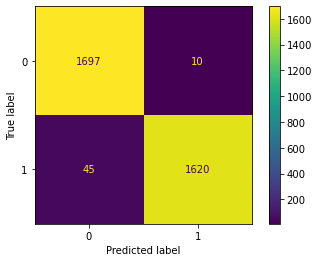

In [53]:
from sklearn.metrics import accuracy_score, precision_score, plot_confusion_matrix

#confusion matrix on validation set
plot_confusion_matrix(rf, X_val_vec, y_val);

### Models using TF-IDF Vectorizer 
- training set
- validation set

I needed to research ways to run effective vectorizers and found [this resource](https://github.com/smashley-eakland/tweet-nlp-analysis/blob/main/NLP.ipynb).

In [54]:
# MODELS using 2nd TF-IDF Vectorizer 
# Using training set 

from sklearn.metrics import recall_score

models = [lsvc, mnb, dt, rf]
scores = {}

for model in models:
    model.fit(X_train_tfidf, y_train)
    y_pred= model.predict(X_test_tfidf2)
    Accuracy = accuracy_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred)

    scores[model] = ('Accuracy:', Accuracy), ('Recall:', Recall)


In [55]:
for key, value in scores.items():
    print(f"Model name - {key}, accuracy - {round(value[0][1],5)}, recall {round(value[1][1], 5)}")

Model name - LinearSVC(), accuracy - 0.99385, recall 0.98985
Model name - MultinomialNB(), accuracy - 0.97865, recall 0.98656
Model name - DecisionTreeClassifier(), accuracy - 0.99177, recall 0.99089
Model name - RandomForestClassifier(), accuracy - 0.99577, recall 0.99298


In [56]:
# MODELS using 2nd TF-IDF Vectorizer. 
# The 2nd TF-IDF vectorizer included 10785 columns compared to 26975 columns in the 1st TF-IDF so decided to use the smaller one.
# Using validation set 

from sklearn.metrics import recall_score

models = [lsvc, mnb, dt, rf]
scores = {}

for model in models:
    model.fit(X_train_tfidf, y_train)
    y_pred= model.predict(X_val_tf2)
    Accuracy = accuracy_score(y_val, y_pred)
    Recall = recall_score(y_val, y_pred)

    scores[model] = ('Accuracy:', Accuracy), ('Recall:', Recall)


In [57]:
for key, value in scores.items():
    print(f"Model name - {key}, accuracy - {round(value[0][1],5)}, recall {round(value[1][1], 5)}")


Model name - LinearSVC(), accuracy - 0.98161, recall 0.96997
Model name - MultinomialNB(), accuracy - 0.96234, recall 0.98619
Model name - DecisionTreeClassifier(), accuracy - 0.97005, recall 0.96577
Model name - RandomForestClassifier(), accuracy - 0.9828, recall 0.97357


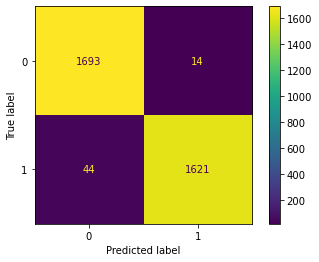

In [58]:
#confusion matrix on validation set
plot_confusion_matrix(rf, X_val_tf2, y_val);

## MODEL Continued
- The random forest classifer did the best compared to the other 3 models while using the count vectorizer & 2nd TF-IDF.
- Moving forward we shall use the TF-IDF since the results were better for this one.

In [59]:
# MODELS using 2nd TF-IDF
# Using Cross-Validation

models = [lsvc, mnb, dt, rf]
from sklearn.model_selection import cross_validate
# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

scores = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_validate(model, X_train_tfidf, y_train, scoring=['recall',"accuracy"], cv=CV)
#    model.fit(X_t_vec, y_train)
#    y_pred= model.predict(X_test_vec)
#    Accuracy = accuracy_score(y_val, y_pred)
#    Recall = recall_score(y_val, y_pred)
    for fold_idx, recall in enumerate(accuracies["test_recall"]):
        Recall = recall
        Accuracy = accuracies["test_accuracy"][fold_idx]
        scores.append((model_name, Accuracy, Recall))
    
cv_df = pd.DataFrame(scores, columns=['Model Name', 'Accuracy', 'Recall'])

In [60]:
cv_df

,Model Name,Accuracy,Recall
0,LinearSVC,0.974296,0.953280
1,LinearSVC,0.974790,0.957256
2,LinearSVC,0.977756,0.963221
3,LinearSVC,0.976767,0.959285
4,LinearSVC,0.977756,0.966236
5,MultinomialNB,0.959466,0.973161
6,MultinomialNB,0.967870,0.983101
7,MultinomialNB,0.969847,0.980119
8,MultinomialNB,0.965398,0.978153
9,MultinomialNB,0.966387,0.977160


*`RandomForestClassifer` seems to be the best performing model.* 

In [61]:
#Let's test on best model w/o CV
# on validation set 

model = [rf]
scores = {}

for model in model:
    model.fit(X_train_tfidf, y_train)
    y_pred= model.predict(X_val_tf2)
    Accuracy = accuracy_score(y_val, y_pred)
    Recall = recall_score(y_val, y_pred)

    scores[model] = ('Accuracy:', Accuracy), ('Recall:', Recall)

In [62]:
for key, value in scores.items():
    print(f"Model name - {key}, accuracy - {round(value[0][1],5)}, recall {round(value[1][1], 5)}")

Model name - RandomForestClassifier(), accuracy - 0.98488, recall 0.97778


## Evaluation for Best Model 

In [63]:
# using test set 

model = [rf]
scores = {}

for model in model:
    rf_hat = model.predict(X_test_tfidf2)
    Accuracy = accuracy_score(y_test, rf_hat)
    Recall = recall_score(y_test, rf_hat)

    scores[model] = ('Accuracy:', Accuracy), ('Recall:', Recall)

In [64]:
for key, value in scores.items():
    print(f"Model name - {key}, accuracy - {round(value[0][1],5)}, recall {round(value[1][1], 5)}")

Model name - RandomForestClassifier(), accuracy - 0.99563, recall 0.99313


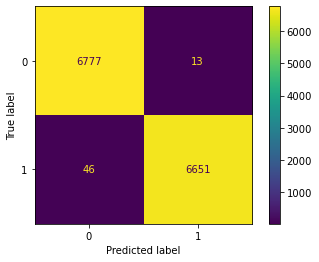

In [65]:
#confusion matrix on validation set
plot_confusion_matrix(rf, X_test_tfidf2, y_test);

# Conclusions

Based on results our final model will be: "Random Forest Classifier  using TF-IDF"

With the following parameters after tuning:

**Accuracy**: 0.99577

**Recall**: 0.99242

Because of the following reasons:

1) It has high accuracy and recall.

In a future project, additional preprocessing steps & token patterns can be used for count vectorizer + tf-idf to attempt to get better metrics. 

In conclusion, this data tells us that twitter can use NLP to predict whether if a tweet is related to covid and be able to provide resources to those positing about it.


